In [1]:
import json
import matplotlib.pyplot as plt
import os

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
import re

### sentence lengths

In [3]:
with open(f'doc_lens.json') as json_file:
        lens = json.load(json_file)
df = pd.DataFrame([[k,v] for k,v in lens.items()], columns=['filename', 'doc length'])
df.describe()

,doc length
count,861.000000
mean,69.602787
std,97.196493
min,3.000000
25%,10.000000
50%,31.000000
75%,94.000000
max,950.000000


In [4]:
10187 / sum(lens.values()) * 100

16.99873181150714

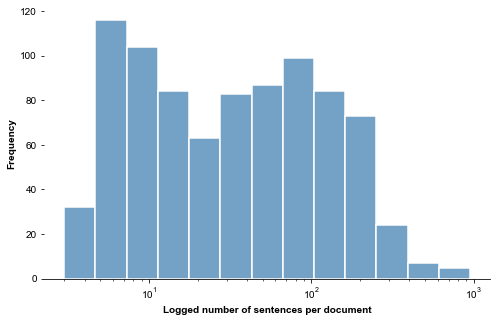

In [5]:
fig, ax = plt.subplots(figsize=(8.0,5.0))
sns.despine(left=True)
sns.set_style("whitegrid", {"grid.color": ".9", "grid.linestyle": "-"})
sns.set_context("talk")

# creating the bar plot
#plt.xticks(rotation=45)
sns.histplot(ax=ax, data=df,  x='doc length', color ='steelblue', log_scale=True)

plt.xlabel("Logged number of sentences per document", fontweight='bold')
plt.ylabel("Frequency", fontweight='bold')

plt.savefig("doclengths.pdf", format="pdf", bbox_inches="tight")

plt.show()

#df.hist(column='doc length')


### POS counts

In [6]:
with open(f'poscounts.json') as json_file:
        poscounts_data = json.load(json_file)
df = pd.DataFrame([[k,v] for k,v in poscounts_data.items()], columns=['POS', 'count'])
df['percentage'] = round((df['count'] / df['count'].sum())*100,2)

In [7]:
df = df.sort_values(by=['count'], ascending=False)
df

,POS,count,percentage
0,NOUN,184749,18.48
3,ADP,134864,13.49
4,DET,119618,11.97
2,PUNCT,110436,11.05
9,VERB,93474,9.35
6,ADJ,73742,7.38
1,PROPN,68451,6.85
12,ADV,52236,5.23
5,PRON,45417,4.54
10,AUX,39275,3.93


In [6]:
def without_hue(ax, feature):
    total = feature.sum()
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.3
        y = p.get_y() + p.get_height() 
        ax.annotate(percentage, (x, y), size = 15, color='dimgrey')

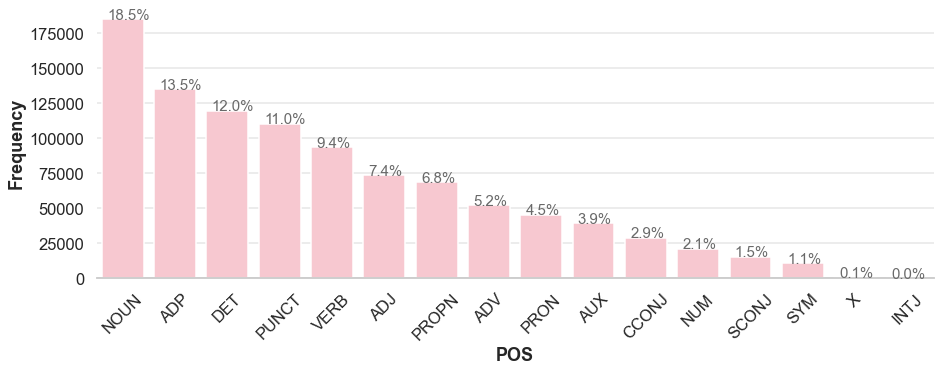

In [9]:
fig, ax = plt.subplots(figsize=(15.0,5.0))
sns.despine(left=True)
sns.set_style("whitegrid", {"grid.color": ".9", "grid.linestyle": "-"})
sns.set_context("talk")

# creating the bar plot
plt.xticks(rotation=45)
sns.barplot(ax=ax, data=df, x='POS', y='count', color ='pink')

plt.xlabel("POS", fontweight='bold')
plt.ylabel("Frequency", fontweight='bold')
without_hue(ax,df['count'])
plt.savefig("posdistribution.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [10]:
def get_nr_value(nr):
    if number == '1': 
        number_value = "First person"
    elif number == '2': 
        number_value = "Second person"
    elif number == '3': 
        number_value = "Third person"
    return number_value

In [11]:
number_counts = defaultdict(lambda: defaultdict(lambda : 0))

with open(f'postokendata.json') as json_file:
        postokendata = json.load(json_file)

pers_pron_count = 0        
for word, posdata in postokendata['PRON'].items():
    for postag, freq in posdata.items():
        if 'excl' not in postag and 'onbep' not in postag and 'betr' not in postag and 'aanw' not in postag and "vb" not in postag:
            pers_pron_count += freq
            #print(word, postag, freq)
            found = False
            for x in ['ev', 'mv']:
                if x in postag:
                    try: 
                        number = re.search(re.compile(r"[1-3]", flags=re.M), postag)[0]
                        if x == 'ev':
                            number_counts['Singular'][get_nr_value(number)] += freq
                        else:
                            number_counts['Plural'][get_nr_value(number)] += freq
                        found = True
                    except:
                        continue
            if found == False:
                if 'haar' in word:
                    try: 
                        number = re.search(re.compile(r"[1-3]", flags=re.M), postag)[0]
                        number_counts['Singular'][get_nr_value(number)] += freq
                        found = True
                    except:
                        continue

In [13]:
print(f"{pers_pron_count} personal pronouns in the data")
print(f"out of {poscounts_data['PRON']} words with the POS 'PRON'")
print(f"{round(pers_pron_count/poscounts_data['PRON'] * 100,2)}% of the words with the PRON pos are personal pronouns")
print(f"{round(pers_pron_count/sum(poscounts_data.values()) * 100,2)}% of the words in the data are personal pronouns")

29083 personal pronouns in the data
out of 45417 words with the POS 'PRON'
64.04% of the words with the PRON pos are personal pronouns
2.91% of the words in the data are personal pronouns


In [418]:
number_counts_list = [[key, k , v]  for key ,data in number_counts.items() for k,v in data.items()]
number_counts_list

[['Singular', 'Third person', 14113],
 ['Singular', 'First person', 1976],
 ['Singular', 'Second person', 934],
 ['Plural', 'Third person', 4536],
 ['Plural', 'First person', 2245],
 ['Plural', 'Second person', 16]]

In [534]:
number_counts_df = pd.DataFrame(number_counts_list, columns = ['count', 'Person', 'freq'])
number_counts_df = number_counts_df.sort_values(by=['Person'], ascending=True)
number_counts_df

,count,Person,freq
1,Singular,First person,1976
4,Plural,First person,2245
2,Singular,Second person,934
5,Plural,Second person,16
0,Singular,Third person,14113
3,Plural,Third person,4536


In [420]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    total= feature.sum()
    for i in range(Number_of_categories):

        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.07
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 15, color='dimgrey')

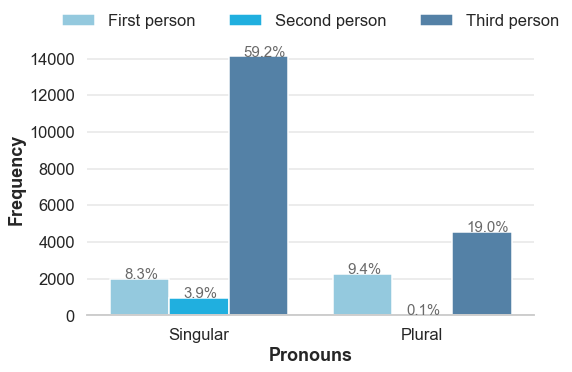

In [517]:
fig, ax = plt.subplots(figsize=(8.0,5.0))
sns.despine(left=True)
sns.set_style("whitegrid", {"grid.color": ".9", "grid.linestyle": "-"})
sns.set_context("talk")

# creating the bar plot
my_pal = {"First person": "skyblue", "Second person": "deepskyblue", "Third person":"steelblue"}

sns.barplot(ax=ax, data=number_counts_df, y="freq", x="count", hue="Person", palette=my_pal)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], loc='lower center', bbox_to_anchor=(.5, 1), ncol=3, frameon=False)


plt.xlabel("Pronouns", fontweight='bold')
plt.ylabel("Frequency", fontweight='bold')
with_hue(ax,number_counts_df['freq'], 2, 3)
plt.savefig("pronoun_numbers.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Third person pronouns

In [9]:
with open(f'postokendata.json') as json_file:
        postokendata = json.load(json_file)
gender_counts = defaultdict(lambda : defaultdict(lambda : 0))
        
        
for word, posdata in postokendata['PRON'].items():
    
    for postag, freq in posdata.items():
        if 'excl' not in postag and 'onbep' not in postag and 'betr' not in postag and 'aanw' not in postag and "vb" not in postag:
            if 'mv' not in postag :
                #print(word, postag, freq)
                try: 
                    number = re.search(re.compile(r"[1-3]", flags=re.M), postag)[0]
                    
                    if number == '3':
                        gender = postag[-4:].replace("|","")
                        #if gender == 'masc' 
                        print(word, postag, freq)
                        if gender not in ['fem', 'masc']:
                            #print(word, postag, freq)
                            if word == 'haar' : 
                                gender = 'fem'
                            elif word == 'zijn' or word == "z'n":
                                gender = 'masc'
                            else:
                                #print(word, postag, freq)
                                continue
                        gendertag = 'Feminine' if gender == 'fem' else 'Masculine' 
                        if 'bez' in postag:
                            gender_counts[gendertag]['Possessive'] += freq
                        elif 'nomin' in postag:
                            if word != 'men':
                                gender_counts[gendertag]['Subject'] += freq
                        else:
                            if word == 'ze':
                                gender_counts[gendertag]['Subject'] += freq
                            else:
                                gender_counts[gendertag]['Object'] += freq
                except:
                        print(f"FAil for {word, postag, freq}")        

zich VNW|refl|pron|obl|red|3|getal 2077
haar VNW|bez|det|stan|vol|3|ev|prenom|zonder|agr 798
haar VNW|pers|pron|obl|vol|3|getal|fem 105
zijn VNW|bez|det|stan|vol|3|ev|prenom|zonder|agr 3205
zijn VNW|pers|pron|nomin|vol|3v|ev|fem 1
het VNW|pers|pron|stan|red|3|ev|onz 4101
hij VNW|pers|pron|nomin|vol|3|ev|masc 3412
zij VNW|pers|pron|nomin|vol|3v|ev|fem 250
zij VNW|bez|det|stan|vol|3|ev|prenom|zonder|agr 1
men VNW|pers|pron|nomin|red|3p|ev|masc 449
hem VNW|pers|pron|obl|vol|3|ev|masc 604
ze VNW|pers|pron|stan|red|3|ev|fem 825
z'n VNW|bez|det|stan|red|3|ev|prenom|zonder|agr 188
zichzelf VNW|refl|pron|obl|nadr|3|getal 133
't VNW|pers|pron|stan|red|3|ev|onz 32
ie VNW|pers|pron|nomin|red|3|ev|masc 53
'ie VNW|pers|pron|nomin|red|3|ev|masc 4
-ie VNW|pers|pron|nomin|red|3|ev|masc 27
z´n VNW|bez|det|stan|red|3|ev|prenom|zonder|agr 2
m VNW|pers|pron|obl|red|3|ev|masc 3
t VNW|pers|pron|stan|red|3|ev|onz 7
´t VNW|pers|pron|stan|red|3|ev|onz 1
'm VNW|pers|pron|obl|red|3|ev|masc 12
hemzelf VNW|pers|pr

In [582]:
gender_counts_list = [[key, k , v]  for key ,data in gender_counts.items() for k,v in data.items()]

In [583]:
gender_counts_list

[['Feminine', 'Possessive', 798],
 ['Feminine', 'Object', 107],
 ['Feminine', 'Subject', 1078],
 ['Masculine', 'Possessive', 3393],
 ['Masculine', 'Subject', 3504],
 ['Masculine', 'Object', 631]]

In [584]:
gender_counts_df = pd.DataFrame(gender_counts_list, columns = ['Gender', 'Tense', 'Freq'])
#gender_counts_df = gender_counts_list.sort_values(by=['Person'], ascending=True)
gender_counts_df = gender_counts_df.reindex([2,1,0,4,5,3])
gender_counts_df

,Gender,Tense,Freq
2,Feminine,Subject,1078
1,Feminine,Object,107
0,Feminine,Possessive,798
4,Masculine,Subject,3504
5,Masculine,Object,631
3,Masculine,Possessive,3393


In [585]:
7789 / sum(gender_counts_df['Freq']) * 100

81.89464830196614

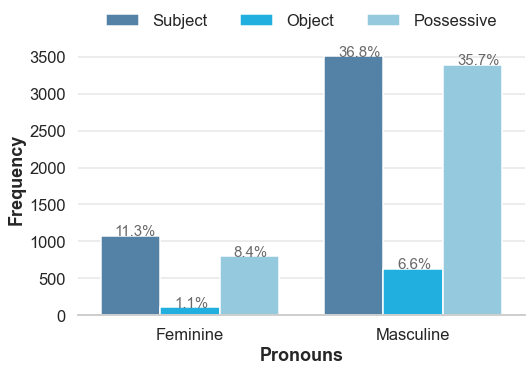

In [586]:
fig, ax = plt.subplots(figsize=(8.0,5.0))
sns.despine(left=True)
sns.set_style("whitegrid", {"grid.color": ".9", "grid.linestyle": "-"})
sns.set_context("talk")

# creating the bar plot
my_pal = {"Possessive": "skyblue", "Object": "deepskyblue", "Subject":"steelblue"}

sns.barplot(ax=ax, data=gender_counts_df, y="Freq", x="Gender", hue="Tense", palette=my_pal)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], loc='lower center', bbox_to_anchor=(.5, 1), ncol=3, frameon=False)


plt.xlabel("Pronouns", fontweight='bold')
plt.ylabel("Frequency", fontweight='bold')
with_hue(ax,gender_counts_df['Freq'], 2, 3)

plt.savefig("genderplot.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Pronoun counts

In [3]:
with open(f'tokenposdata.json') as json_file:
        data = json.load(json_file)

print(sum([value for v in data['die'].values() for value in v.values()]))
data['zij']

7282


{'PRON': {'VNW|pers|pron|nomin|vol|3p|mv': 481,
  'VNW|pers|pron|nomin|vol|3v|ev|fem': 250,
  'VNW|bez|det|stan|vol|3|ev|prenom|zonder|agr': 1},
 'VERB': {'WW|pv|conj|ev': 22},
 'NOUN': {'N|soort|ev|basis|zijd|stan': 5},
 'AUX': {'WW|pv|conj|ev': 4}}

In [579]:
data['hun']

{'PRON': {'VNW|bez|det|stan|vol|3|mv|prenom|zonder|agr': 1865,
  'VNW|pers|pron|obl|vol|3p|mv': 10},
 'DET': {'VNW|bez|det|stan|vol|3|mv|prenom|zonder|agr': 8}}

In [567]:
for neopronoun in ['dee','dem', 'dijr', 'dij', 'dem','dijr', \
                   'nij', 'ner', 'nijr', 'vij', 'vijn', 'vijns', \
                   'zhij', 'zhaar', 'zhaar', 'zem', 'zeer', 'zee']:
    try: 
        print(neopronoun, data[neopronoun])
    except KeyError:
        print(f"{neopronoun}, -")

dee, -
dem, -
dijr, -
dij, -
dem, -
dijr, -
nij, -
ner, -
nijr, -
vij {'ADJ': {'ADJ|vrij|basis|zonder': 1}}
vijn, -
vijns, -
zhij, -
zhaar, -
zhaar, -
zem, -
zeer {'ADV': {'BW': 288}, 'DET': {'BW': 7}}
zee {'PROPN': {'SPEC|deeleigen': 22}, 'NOUN': {'N|soort|ev|basis|zijd|stan': 120}}


In [568]:
data['ze']

{'PRON': {'VNW|pers|pron|stan|red|3|mv': 1882,
  'VNW|pers|pron|stan|red|3|ev|fem': 825}}

### Referents Analysis

with singletons

In [22]:
with open(f'doc_cluster_info.json') as json_file:
        ref_data = json.load(json_file)
ref_data = ref_data['refs_per_sent']

df = pd.DataFrame([[k,v] for k,v in ref_data.items()], columns=['sentence_id', 'referents'])
df.describe()

,referents
count,59928.000000
mean,4.831481
std,3.336285
min,0.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,54.000000


In [23]:
df.median()

<ipython-input-23-6d467abf240d>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.median()


referents    4.0
dtype: float64

without singletons

In [31]:
with open(f'doc_cluster_info_singl_excl.json') as json_file:
        ref_data = json.load(json_file)
ref_data = ref_data['refs_per_sent']

df = pd.DataFrame([[k,v] for k,v in ref_data.items()], columns=['sentence_id', 'referents'])
print(df.median())
df.describe()



referents    2.0
dtype: float64


<ipython-input-31-945aa3780d47>:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df.median())


,referents
count,59928.000000
mean,1.876468
std,1.706620
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,18.000000


### Cluster analysis
with singletons

In [40]:
with open(f'doc_cluster_info.json') as json_file:
        ref_data = json.load(json_file)
ref_data = ref_data['clusters_per_doc']

df = pd.DataFrame([[k,v] for k,v in ref_data.items()], columns=['doc_id', 'clusters'])
df.describe()

,clusters
count,861.000000
mean,237.876887
std,356.264239
min,2.000000
25%,39.000000
50%,116.000000
75%,327.000000
max,4698.000000


In [41]:
print(sum(ref_data.values()))

204812


without singletons

In [43]:
with open(f'doc_cluster_info_singl_excl.json') as json_file:
        ref_data = json.load(json_file)
ref_data = ref_data['clusters_per_doc']

df = pd.DataFrame([[k,v] for k,v in ref_data.items()], columns=['sentence_id', 'referents'])
print(df.median())
df.describe()

referents    16.0
dtype: float64


<ipython-input-43-5903707b35e7>:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df.median())


,referents
count,861.000000
mean,32.199768
std,42.885944
min,0.000000
25%,6.000000
50%,16.000000
75%,43.000000
max,439.000000


In [44]:
print(sum(ref_data.values()))

27724


In [ ]:
32.2 & 16 & 42.9 & 0 & 439

In [18]:
with open(f'doc_cluster_info_singl_excl.json') as json_file:
        ref_data = json.load(json_file)
ref_data = ref_data['refs_per_cluster']

df = pd.DataFrame([[k,v] for k,v in ref_data.items()], columns=['sentence_id', 'referents'])
print(df.median())
df.describe()

referents    2.0
dtype: float64


<ipython-input-18-e6a5e5f0faa3>:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df.median())


,referents
count,27724.000000
mean,4.056161
std,7.223182
min,2.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,307.000000


In [22]:
df = pd.DataFrame([[k,v] for k,v in ref_data.items()], columns=['sentence_id', 'referents'])
df

,sentence_id,referents
0,..\..\Data\Sonar_corpus_conll_splits_singleton...,2
1,..\..\Data\Sonar_corpus_conll_splits_singleton...,8
2,..\..\Data\Sonar_corpus_conll_splits_singleton...,2
3,..\..\Data\Sonar_corpus_conll_splits_singleton...,3
4,..\..\Data\Sonar_corpus_conll_splits_singleton...,5
...,...,...
27719,..\..\Data\Sonar_corpus_conll_splits_singleton...,3
27720,..\..\Data\Sonar_corpus_conll_splits_singleton...,2
27721,..\..\Data\Sonar_corpus_conll_splits_singleton...,2
27722,..\..\Data\Sonar_corpus_conll_splits_singleton...,2


## Nouns

In [62]:
with open(f'noun_freqs.json') as json_file:
        noundata = json.load(json_file)
data = []
for k,v in noundata.items():
    row = [k]
    for value in v.values():
        if value == 'f':
            row.append('Female')
        elif value == 'm':
            row.append('Male')
        else:
            row.append(value)
    data.append(row)

df = pd.DataFrame(data, columns=['noun','new noun', 'gender','freq'])
df['percentage'] = round((df['freq'] / df['freq'].sum())*100,2)
df

,noun,new noun,gender,freq,percentage
0,tante,familielid,Female,10,0.40
1,oom,familielid,Male,10,0.40
2,jongen,kind,Male,73,2.94
3,meisje,kind,Female,23,0.93
4,man,persoon,Male,301,12.11
...,...,...,...,...,...
83,vriend,maat,Male,45,1.81
84,vriendin,maat,Female,28,1.13
85,vriendje,partner,Male,3,0.12
86,vriendinnetje,partner,Female,0,0.00


In [63]:
df = df.sort_values(by=['freq'], ascending=False)
df

,noun,new noun,gender,freq,percentage
4,man,persoon,Male,301,12.11
7,vrouwen,personen,Female,244,9.81
45,koning,staatshoofd,Male,168,6.76
5,vrouw,persoon,Female,158,6.36
6,mannen,personen,Male,132,5.31
...,...,...,...,...,...
54,politievrouw,politieagent,Female,0,0.00
51,jongedame,jongere,Female,0,0.00
38,opa,grootouder,Male,0,0.00
35,kleindochters,kleinkinderen,Female,0,0.00


In [75]:
sum(df.loc[df['gender'] == 'Female']['freq'])/ sum(df['freq']) * 100

41.02976669348351

In [74]:
sum(df.loc[df['gender'] == 'Male']['freq']) / sum(df['freq']) * 100

58.9702333065165

In [71]:
df = df.loc[df['freq'] > 0]

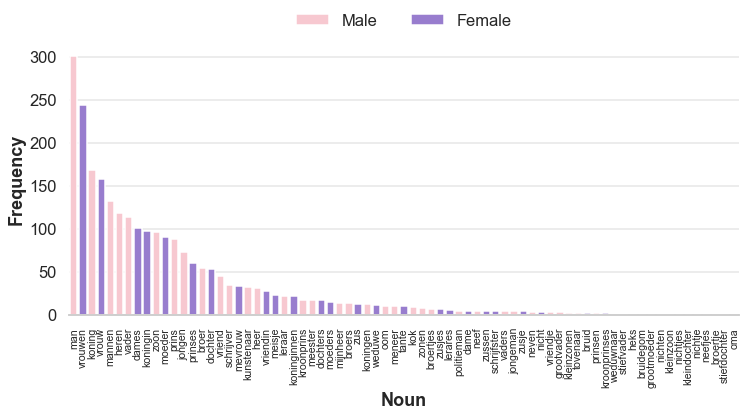

In [73]:
fig, ax = plt.subplots(figsize=(12.0,5.0))
sns.despine(left=True)
sns.set_style("whitegrid", {"grid.color": ".9", "grid.linestyle": "-"})
sns.set_context("talk")

# creating the bar plot
plt.xticks(rotation=90, fontsize=10.5)
my_pal = {"Female": "mediumpurple", "Male": "pink"}

sns.barplot(ax=ax, data=df, x='noun', y='freq', hue="gender", palette=my_pal, dodge=False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], loc='lower center', bbox_to_anchor=(.5, 1), ncol=3, frameon=False)

plt.xlabel("Noun", fontweight='bold')
plt.ylabel("Frequency", fontweight='bold')

plt.savefig("noundistribution.pdf", format="pdf", bbox_inches="tight")
plt.show()